<a href="https://colab.research.google.com/github/ahmedsyed-s/NetworkAnomalyDetection/blob/main/Network_anomaly_detection1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Anomaly Detection in Network Traffic Using Autoencoders and Latent Space Clustering


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load dataset ()
data = pd.read_csv("/content/dataset/CSV/Monday-WorkingHours.pcap_ISCX.csv")

In [ ]:
# Preview the data
print("Dataset shape:", data.shape)
print("Columns:", data.columns.tolist())
print("Missing values per column:\n", data.isnull().sum())
print("Label distribution (if available):\n", data['Label'].value_counts() if 'Label' in data.columns else "No Label column found")

Dataset shape: (529918, 79)
Columns: [' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', ' PSH Flag C

In [ ]:
# checking the data head

print("\nData Head:\n", data.head())


Data Head:
     Destination Port   Flow Duration   Total Fwd Packets  \
0              49188               4                   2   
1              49188               1                   2   
2              49188               1                   2   
3              49188               1                   2   
4              49486               3                   2   

    Total Backward Packets  Total Length of Fwd Packets  \
0                        0                           12   
1                        0                           12   
2                        0                           12   
3                        0                           12   
4                        0                           12   

    Total Length of Bwd Packets   Fwd Packet Length Max  \
0                             0                       6   
1                             0                       6   
2                             0                       6   
3                             0    

In [ ]:
# Drop non-numeric and non-useful columns
data = data.select_dtypes(include=[np.number]).dropna()

In [ ]:
# Extract labels before dropping
labels = data["Label"] if "Label" in data.columns else None

In [ ]:
# Check for infinities or large values
print("Any infinity in data?", np.isinf(data).values.any())
print("Any NaN in data?", np.isnan(data).values.any())


Any infinity in data? True
Any NaN in data? False


In [ ]:
# Find which columns contain infinity
infinity_cols = data.columns[np.isinf(data).any()]
print("Columns with infinity values:", infinity_cols.tolist())

Columns with infinity values: ['Flow Bytes/s', ' Flow Packets/s']


In [ ]:
#show a sample for a specific column

print("\nSample of 'Flow Bytes/s':\n", data['Flow Bytes/s'].sample(5))


Sample of 'Flow Bytes/s':
 526229          0.0
251887          0.0
328830    4000000.0
178045    9250000.0
337281          0.0
Name: Flow Bytes/s, dtype: float64


In [ ]:
# print the maximum value in this column

print("Maximum value in 'Flow Bytes/s':", data['Flow Bytes/s'].max())

Maximum value in 'Flow Bytes/s': inf


In [ ]:
# Optionally, replace infinities with NaN and drop them
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

<Figure size 1200x600 with 0 Axes>

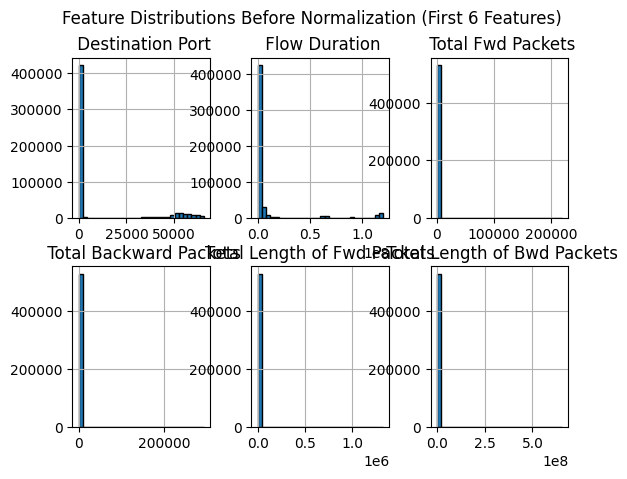

In [ ]:
# Visualize some feature distributions before normalization
plt.figure(figsize=(12,6))
data.iloc[:, :6].hist(bins=30, layout=(2,3), edgecolor='black')
plt.suptitle("Feature Distributions Before Normalization (First 6 Features)")
plt.show()

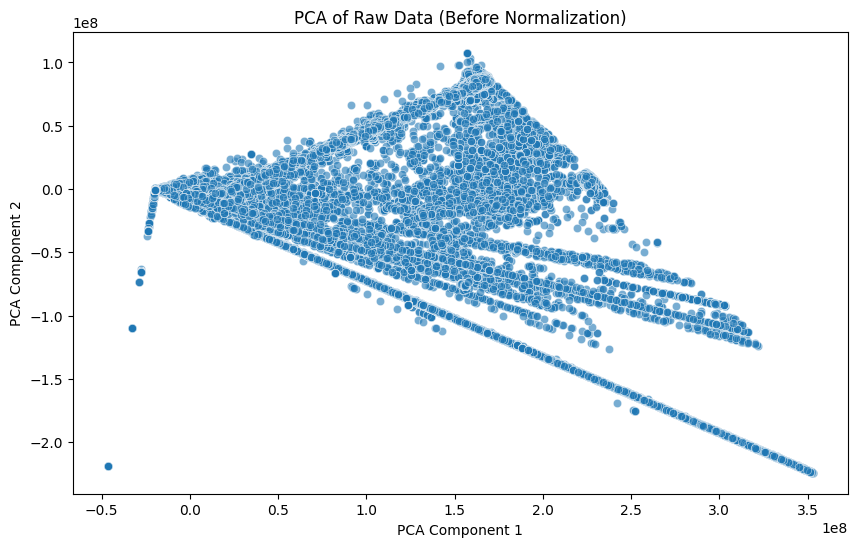

In [ ]:
# Visualize the data before normalization
from sklearn.decomposition import PCA

# Perform PCA on raw (unscaled) data
pca_raw = PCA(n_components=2)
data_raw_pca = pca_raw.fit_transform(data)

# Visualize raw data in 2D
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_raw_pca[:, 0], y=data_raw_pca[:, 1], alpha=0.6)
plt.title("PCA of Raw Data (Before Normalization)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [ ]:
# Normalize data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

In [ ]:
# show the normalized data

import pandas as pd
data_scaled_df = pd.DataFrame(data_scaled, columns=data.columns)
print("\nNormalized Data Head:\n", data_scaled_df.head())
print("\nNormalized Data Describe:\n", data_scaled_df.describe())


Normalized Data Head:
     Destination Port   Flow Duration   Total Fwd Packets  \
0           1.803407        -0.36151           -0.009406   
1           1.803407        -0.36151           -0.009406   
2           1.803407        -0.36151           -0.009406   
3           1.803407        -0.36151           -0.009406   
4           1.817345        -0.36151           -0.009406   

    Total Backward Packets  Total Length of Fwd Packets  \
0                 -0.00982                    -0.083587   
1                 -0.00982                    -0.083587   
2                 -0.00982                    -0.083587   
3                 -0.00982                    -0.083587   
4                 -0.00982                    -0.083587   

    Total Length of Bwd Packets   Fwd Packet Length Max  \
0                     -0.006693               -0.412139   
1                     -0.006693               -0.412139   
2                     -0.006693               -0.412139   
3                     -0

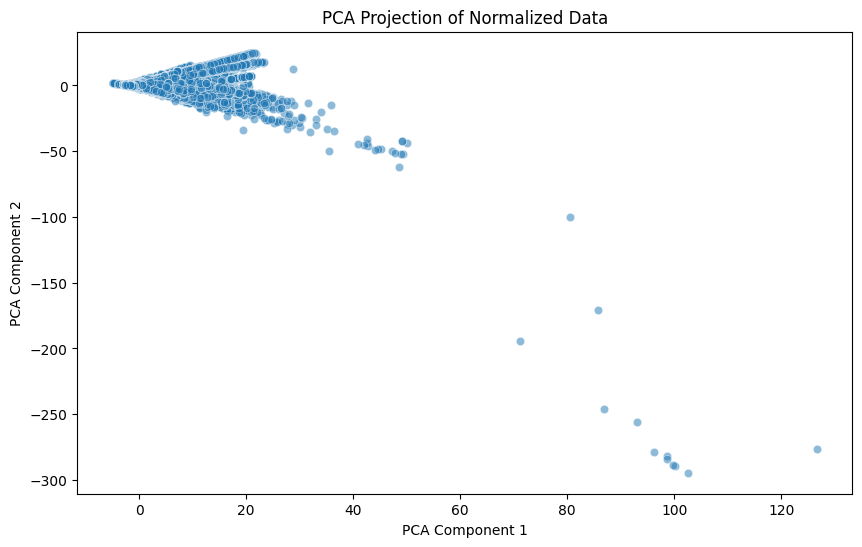

In [ ]:
from sklearn.decomposition import PCA

# Reduce to 2D using PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

# Plot the normalized data
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], alpha=0.5)
plt.title("PCA Projection of Normalized Data")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

<Figure size 1200x600 with 0 Axes>

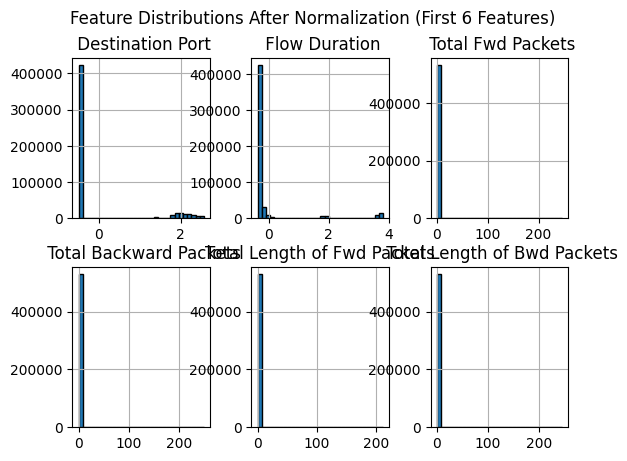

In [ ]:
# Visualize feature distributions after normalization
plt.figure(figsize=(12,6))
pd.DataFrame(data_scaled, columns=data.columns).iloc[:, :6].hist(bins=30, layout=(2,3), edgecolor='black')
plt.suptitle("Feature Distributions After Normalization (First 6 Features)")
plt.show()

In [ ]:
# Split data for training and validation
X_train, X_val = train_test_split(data_scaled, test_size=0.2, random_state=42)

## Model 1

In [ ]:
--- Cancel
# Autoencoder architecture
def build_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(input_layer)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(0.2)(encoded)
    encoded = Dense(32, activation='relu')(encoded)
    latent = Dense(16, activation='relu', name='latent')(encoded)
    decoded = Dense(32, activation='relu')(latent)
    decoded = Dense(64, activation='relu')(decoded)
    output_layer = Dense(input_dim, activation='linear')(decoded)

    model = Model(inputs=input_layer, outputs=output_layer)
    encoder = Model(inputs=input_layer, outputs=latent)
    return model, encoder

In [ ]:
input_dim = X_train.shape[1]
autoencoder, encoder = build_autoencoder(input_dim)
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping to prevent overfitting and erratic val loss
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Train the model
history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_val, X_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
3310/3310 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.1105 - val_loss: 1.4212
Epoch 2/50
3310/3310 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.0682 - val_loss: 2.1109
Epoch 3/50
3310/3310 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0697 - val_loss: 3.7745
Epoch 4/50
3310/3310 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 0.0790 - val_loss: 0.5529
Epoch 5/50
3310/3310 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 0.0865 - val_loss: 5.1615
Epoch 6/50
3310/3310 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 0.0719 - val_loss: 0.6067
Epoch 7/50
3310/3310 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.0604 - val_loss: 1.3189
Epoch 8/50
3310/3310 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.0540 - val_loss: 5.7072
Epoch 9/50
3310/3310 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.0981 - val_loss: 5.3815
Epoch 10/50
3310/3310 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.0677 - val_loss: 11.8162
Epoch 11/50
3310/3310 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.0798 - val_loss: 2.6383
Epoch 12/50
3310/3

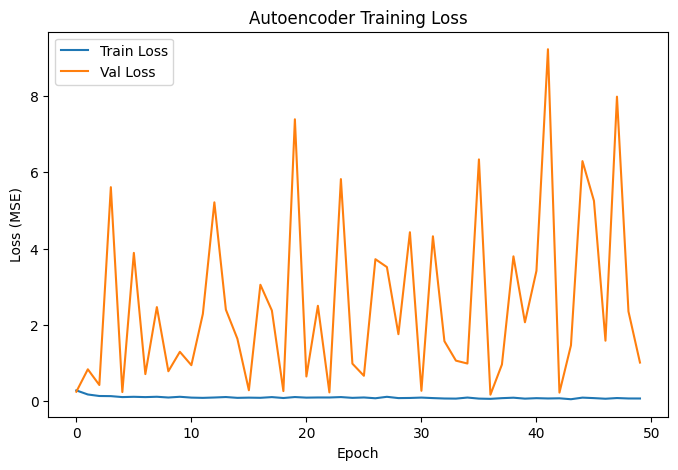

In [ ]:
# Plot training history
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

## Model 2

Epoch 1/100
6619/6619 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - loss: 0.0567 - val_loss: 4.6634
Epoch 2/100
6619/6619 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - loss: 0.0439 - val_loss: 5.3804
Epoch 3/100
6619/6619 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 0.0491 - val_loss: 4.9097
Epoch 4/100
6619/6619 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - loss: 0.0429 - val_loss: 3.2123
Epoch 5/100
6619/6619 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - loss: 0.0408 - val_loss: 3.5104
Epoch 6/100
6619/6619 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - loss: 0.0438 - val_loss: 4.3236
Epoch 7/100
6619/6619 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - loss: 0.0421 - val_loss: 3.0243
Epoch 8/100
6619/6619 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - loss: 0.0405 - val_loss: 2.2105
Epoch 9/100
6619/6619 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 0.0372 - val_loss: 3.4905
Epoch 10/100
6619/6619 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 0.0375 - val_loss: 2.0115
Epoch 11/100
6619/6619 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 0.0339 - val_loss: 2.4296
Epoch 12

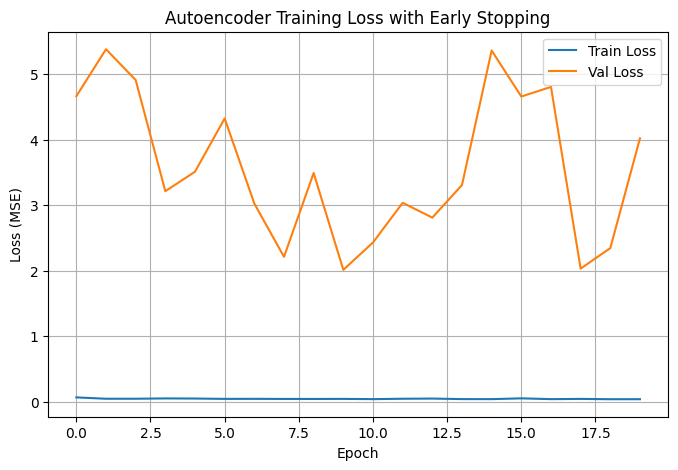

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Compile model with lower learning rate
autoencoder.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')

# Early stopping to prevent overfitting and erratic val loss
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train with updated parameters
history = autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, X_val),
    callbacks=[early_stop],
    verbose=1
)

# Plot training & validation loss for monitoring
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Autoencoder Training Loss with Early Stopping')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

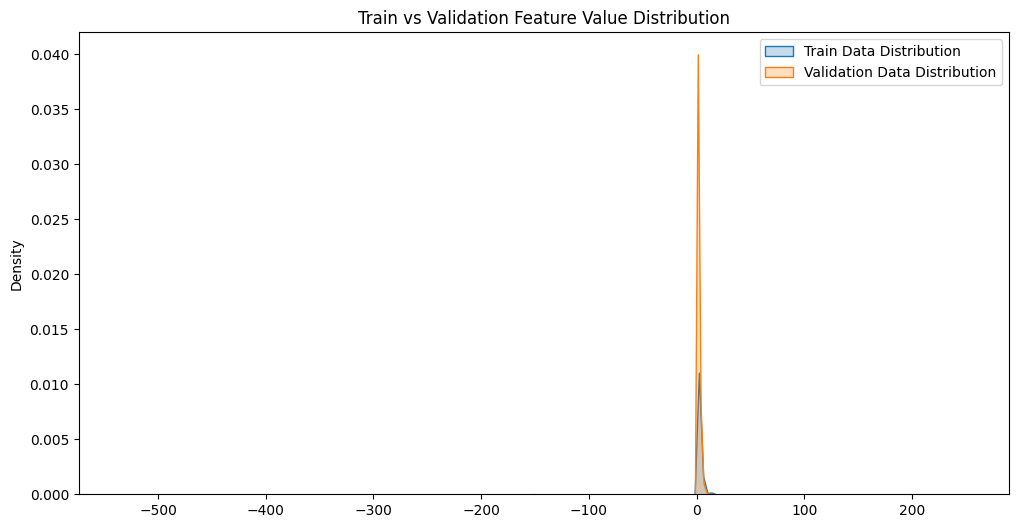

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.kdeplot(X_train.flatten(), label='Train Data Distribution', fill=True, bw_adjust=0.5)
sns.kdeplot(X_val.flatten(), label='Validation Data Distribution', fill=True, bw_adjust=0.5)
plt.legend()
plt.title("Train vs Validation Feature Value Distribution")
plt.show()

## Model 3

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers

def build_simple_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    # Encoding
    encoded = Dense(32, activation='relu')(input_layer)
    encoded = Dense(16, activation='relu')(encoded)
    latent = Dense(8, activation='relu', name='latent')(encoded)
    # Decoding
    decoded = Dense(16, activation='relu')(latent)
    decoded = Dense(32, activation='relu')(decoded)
    output_layer = Dense(input_dim, activation='linear')(decoded)

    model = Model(inputs=input_layer, outputs=output_layer)
    encoder = Model(inputs=input_layer, outputs=latent)
    return model, encoder

In [ ]:
autoencoder, encoder = build_simple_autoencoder(input_dim)
autoencoder.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_val, X_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
3310/3310 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.5766 - val_loss: 0.4313
Epoch 2/50
3310/3310 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 0.3585 - val_loss: 0.3474
Epoch 3/50
3310/3310 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.3058 - val_loss: 0.2963
Epoch 4/50
3310/3310 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 0.2513 - val_loss: 0.2409
Epoch 5/50
3310/3310 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.2282 - val_loss: 0.2046
Epoch 6/50
3310/3310 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.2197 - val_loss: 0.1844
Epoch 7/50
3310/3310 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.1828 - val_loss: 0.1729
Epoch 8/50
3310/3310 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 0.1551 - val_loss: 0.1588
Epoch 9/50
3310/3310 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.1419 - val_loss: 0.1553
Epoch 10/50
3310/3310 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.1467 - val_loss: 0.1419
Epoch 11/50
3310/3310 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.1364 - val_loss: 0.1351
Epoch 12/50
3310/33

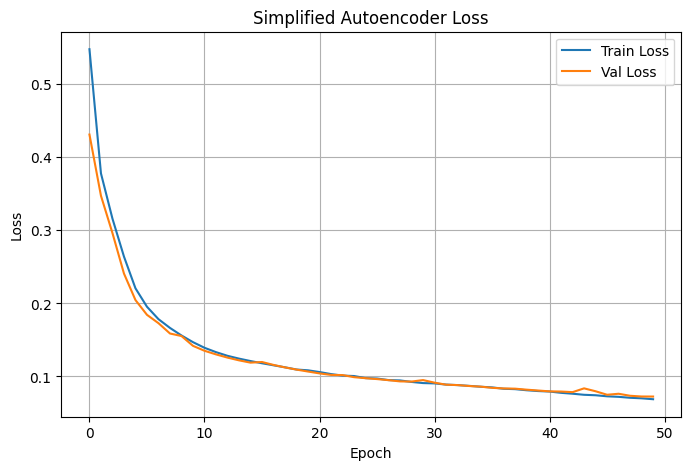

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Simplified Autoencoder Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
autoencoder.save("autoencoder_monday_model.h5")
encoder.save("encoder_monday_model.h5")

16547/16547 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step


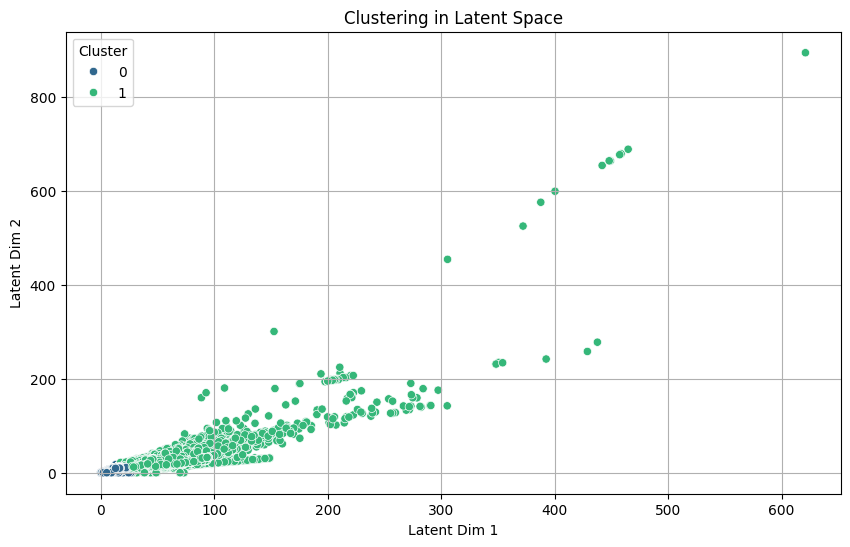

KeyboardInterrupt: 

In [ ]:
# Latent Representation + KMeans Clustering

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

# Get latent representations of the full dataset
latent_reps = encoder.predict(data_scaled)

# KMeans clustering (you can try other algorithms too)
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(latent_reps)

# Visualization of latent space
plt.figure(figsize=(10, 6))
sns.scatterplot(x=latent_reps[:, 0], y=latent_reps[:, 1], hue=clusters, palette='viridis')
plt.title("Clustering in Latent Space")
plt.xlabel("Latent Dim 1")
plt.ylabel("Latent Dim 2")
plt.grid(True)
plt.legend(title="Cluster")
plt.show()

# Optional: evaluate cluster quality (if no labels, use silhouette only)
score = silhouette_score(latent_reps, clusters)
print(f"Silhouette Score: {score:.4f}")

In [ ]:
from sklearn.utils import resample

# Sample 5000 points (or fewer if your data is smaller)
sample_latent, sample_clusters = resample(latent_reps, clusters, n_samples=10000, random_state=42)

score = silhouette_score(sample_latent, sample_clusters)
print(f"Silhouette Score (sampled): {score:.4f}")

Silhouette Score (sampled): 0.7399


In [ ]:
# Reconstruct the input
reconstructions = autoencoder.predict(data_scaled)

# Compute mean squared error per sample
mse = np.mean(np.power(data_scaled - reconstructions, 2), axis=1)

# Set anomaly threshold (e.g. 95th percentile)
threshold = np.percentile(mse, 95)
print(f"Anomaly Threshold: {threshold:.4f}")

# Identify anomalies
anomalies = mse > threshold
print("Number of anomalies detected:", np.sum(anomalies))

16547/16547 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step
Anomaly Threshold: 0.1752
Number of anomalies detected: 26471


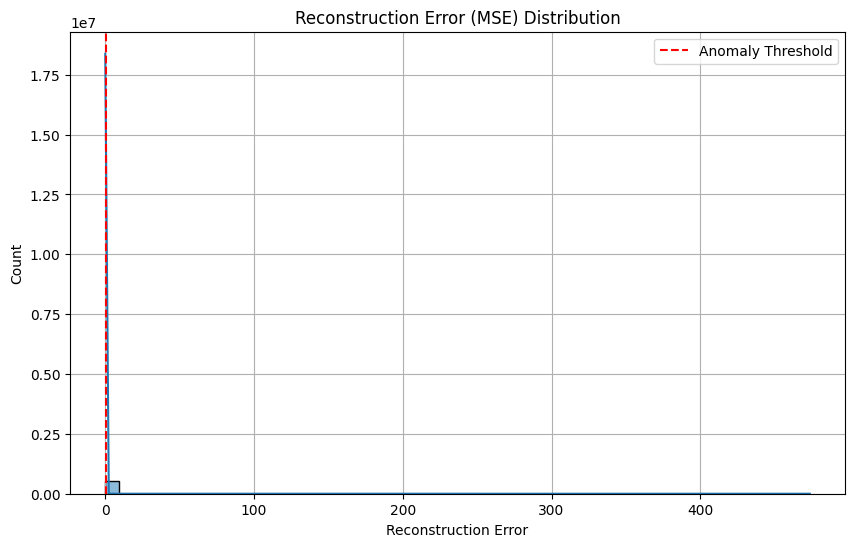

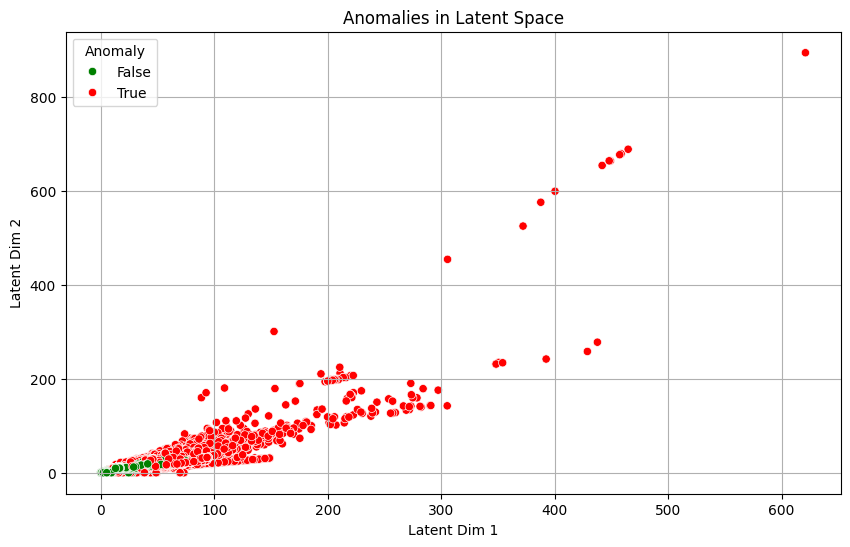

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(mse, bins=50, kde=True)
plt.axvline(threshold, color='red', linestyle='--', label='Anomaly Threshold')
plt.title("Reconstruction Error (MSE) Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.show()

# If you want to visualize anomalies in latent space
plt.figure(figsize=(10, 6))
sns.scatterplot(x=latent_reps[:, 0], y=latent_reps[:, 1], hue=anomalies, palette={False: "green", True: "red"})
plt.title("Anomalies in Latent Space")
plt.xlabel("Latent Dim 1")
plt.ylabel("Latent Dim 2")
plt.legend(title="Anomaly")
plt.grid(True)
plt.show()

In [ ]:
anomaly_percentage = (np.sum(anomalies) / len(anomalies)) * 100
print(f"Percentage of anomalies detected: {anomaly_percentage:.2f}%")

Percentage of anomalies detected: 5.00%


## Checking anomalies in wednesday data

21607/21607 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step
Number of anomalies detected on Wednesday: 202541
Percentage of anomalies on Wednesday: 29.29%


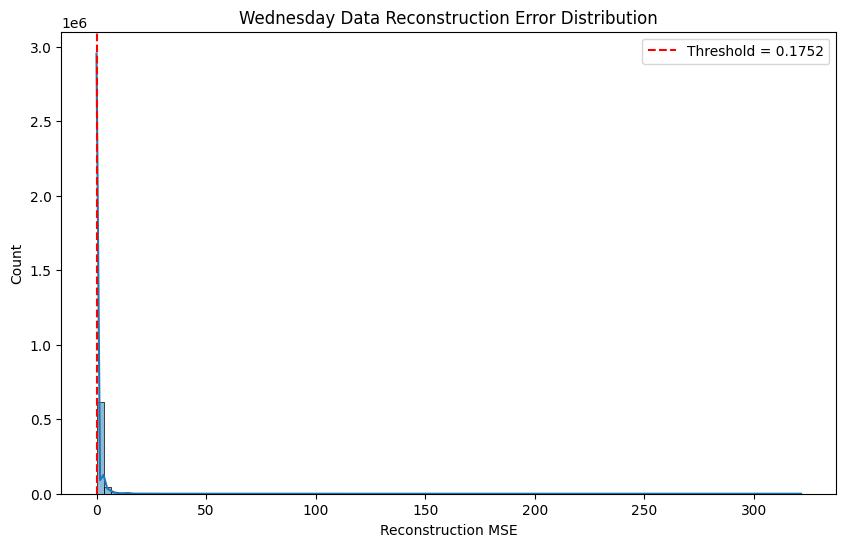

In [ ]:
# Load Wednesday data
wednesday_data = pd.read_csv("/content/dataset/CSV/Wednesday-workingHours.pcap_ISCX.csv")

# Preprocess: keep only numeric, replace inf/-inf, drop NaNs
wednesday_data = wednesday_data.select_dtypes(include=[np.number])
wednesday_data.replace([np.inf, -np.inf], np.nan, inplace=True)
wednesday_data.dropna(inplace=True)

# Normalize using the scaler fitted on Monday data
wednesday_scaled = scaler.transform(wednesday_data)

# Get reconstruction error from autoencoder
wednesday_reconstructions = autoencoder.predict(wednesday_scaled)
wednesday_mse = np.mean(np.power(wednesday_scaled - wednesday_reconstructions, 2), axis=1)

# Detect anomalies using Monday’s threshold
wednesday_anomalies = wednesday_mse > threshold

print(f"Number of anomalies detected on Wednesday: {np.sum(wednesday_anomalies)}")
print(f"Percentage of anomalies on Wednesday: {np.sum(wednesday_anomalies)/len(wednesday_anomalies)*100:.2f}%")

# Optional: visualize MSE distribution with threshold
plt.figure(figsize=(10,6))
sns.histplot(wednesday_mse, bins=100, kde=True)
plt.axvline(threshold, color='r', linestyle='--', label=f"Threshold = {threshold:.4f}")
plt.title("Wednesday Data Reconstruction Error Distribution")
plt.xlabel("Reconstruction MSE")
plt.ylabel("Count")
plt.legend()
plt.show()

In [ ]:
print("Number of input features:", data.shape[1])

Number of input features: 78


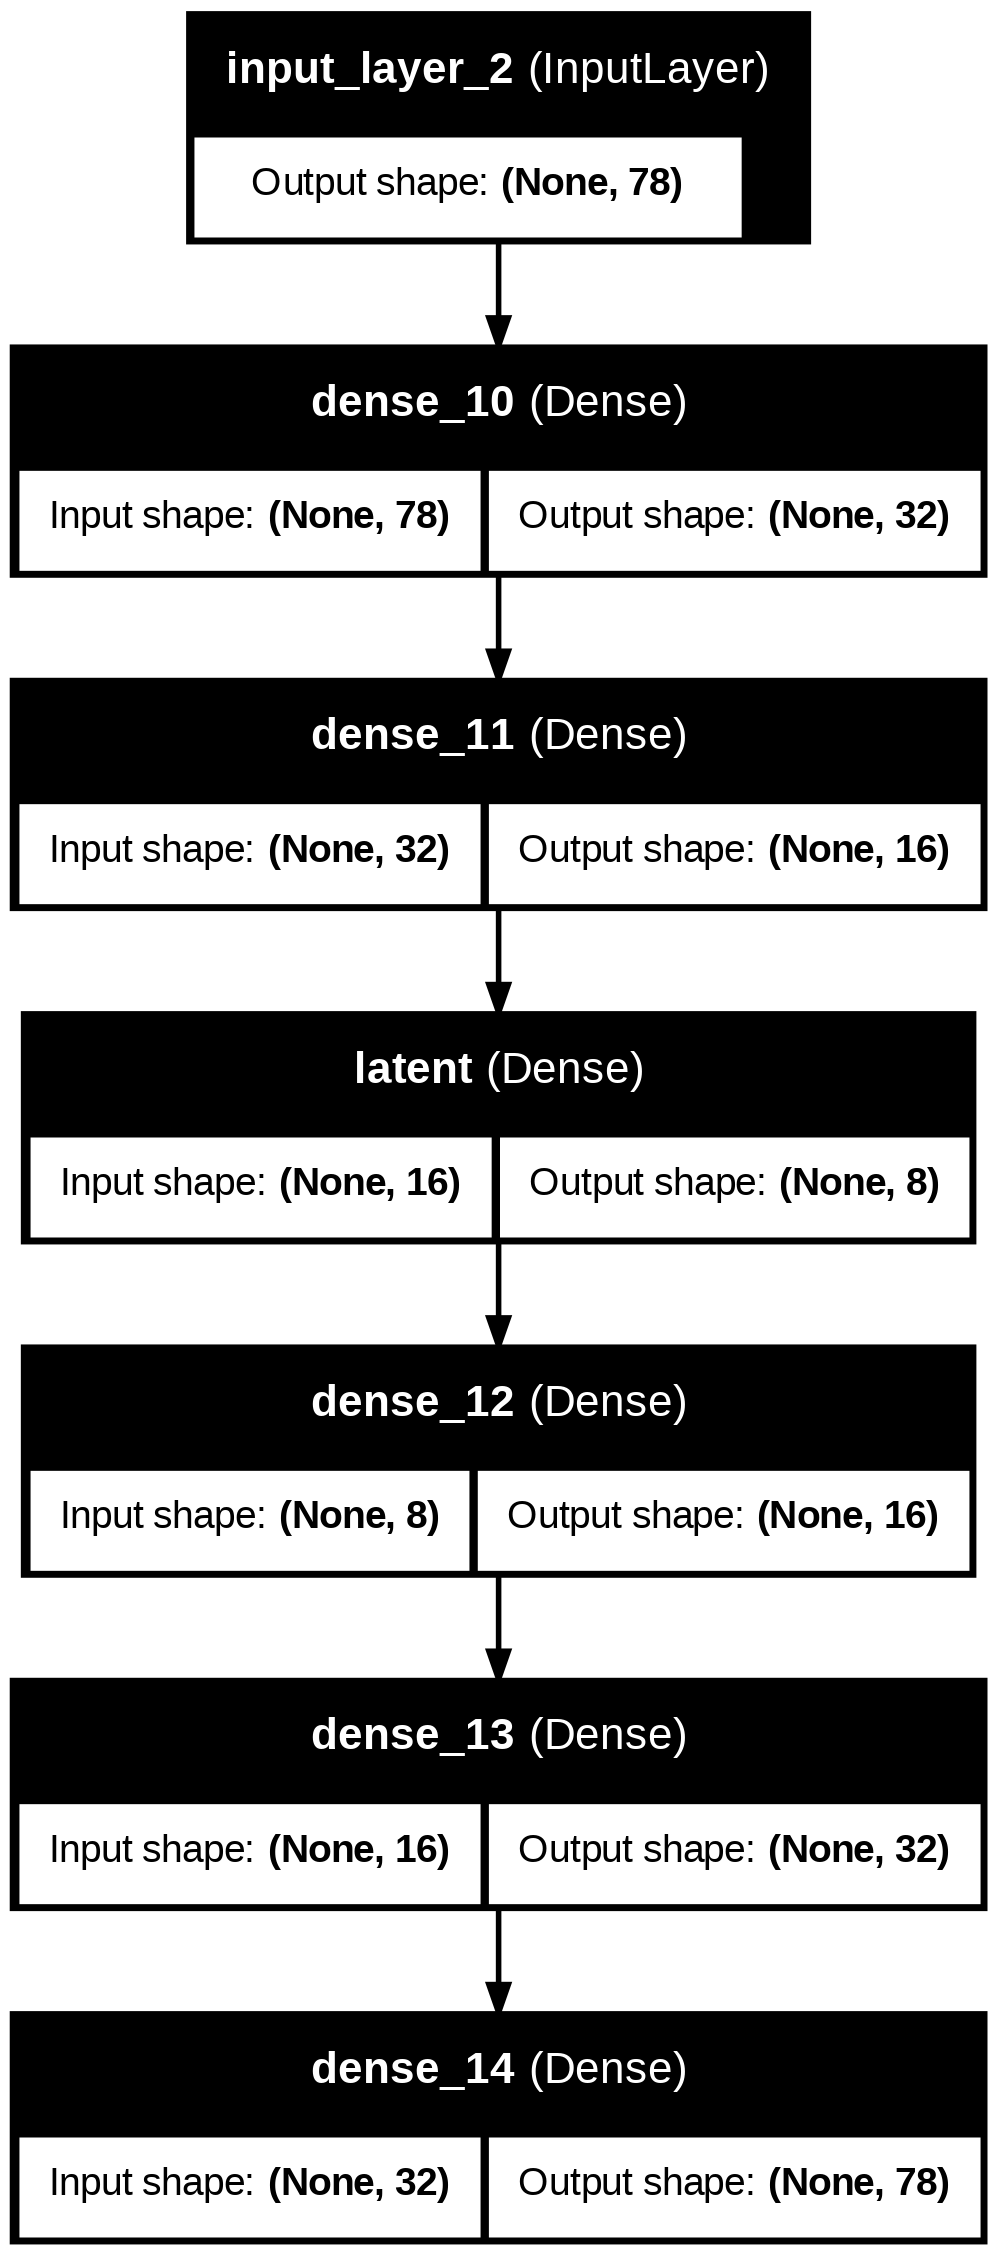

In [ ]:
from tensorflow.keras.utils import plot_model

# Save model diagram as PNG
plot_model(autoencoder, to_file='autoencoder_architecture.png', show_shapes=True, show_layer_names=True)


In [ ]:
selected_features = ['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
                     'Flow Bytes/s', 'Flow Packets/s']

In [ ]:
print(data.columns.intersection(selected_features))

Index(['Flow Bytes/s'], dtype='object')


KeyError: 'Flow Duration'

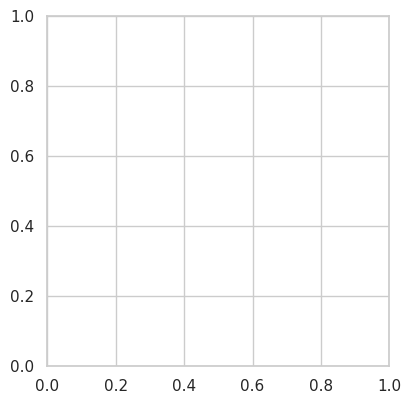

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))

# Plot each selected feature
for idx, feature in enumerate(selected_features):
    plt.subplot(2, 3, idx + 1)
    sns.histplot(data[feature], bins=50, kde=True, color='skyblue')
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.tight_layout()

plt.suptitle("Histograms of Raw Features Before Normalization", fontsize=16, y=1.02)
plt.show()


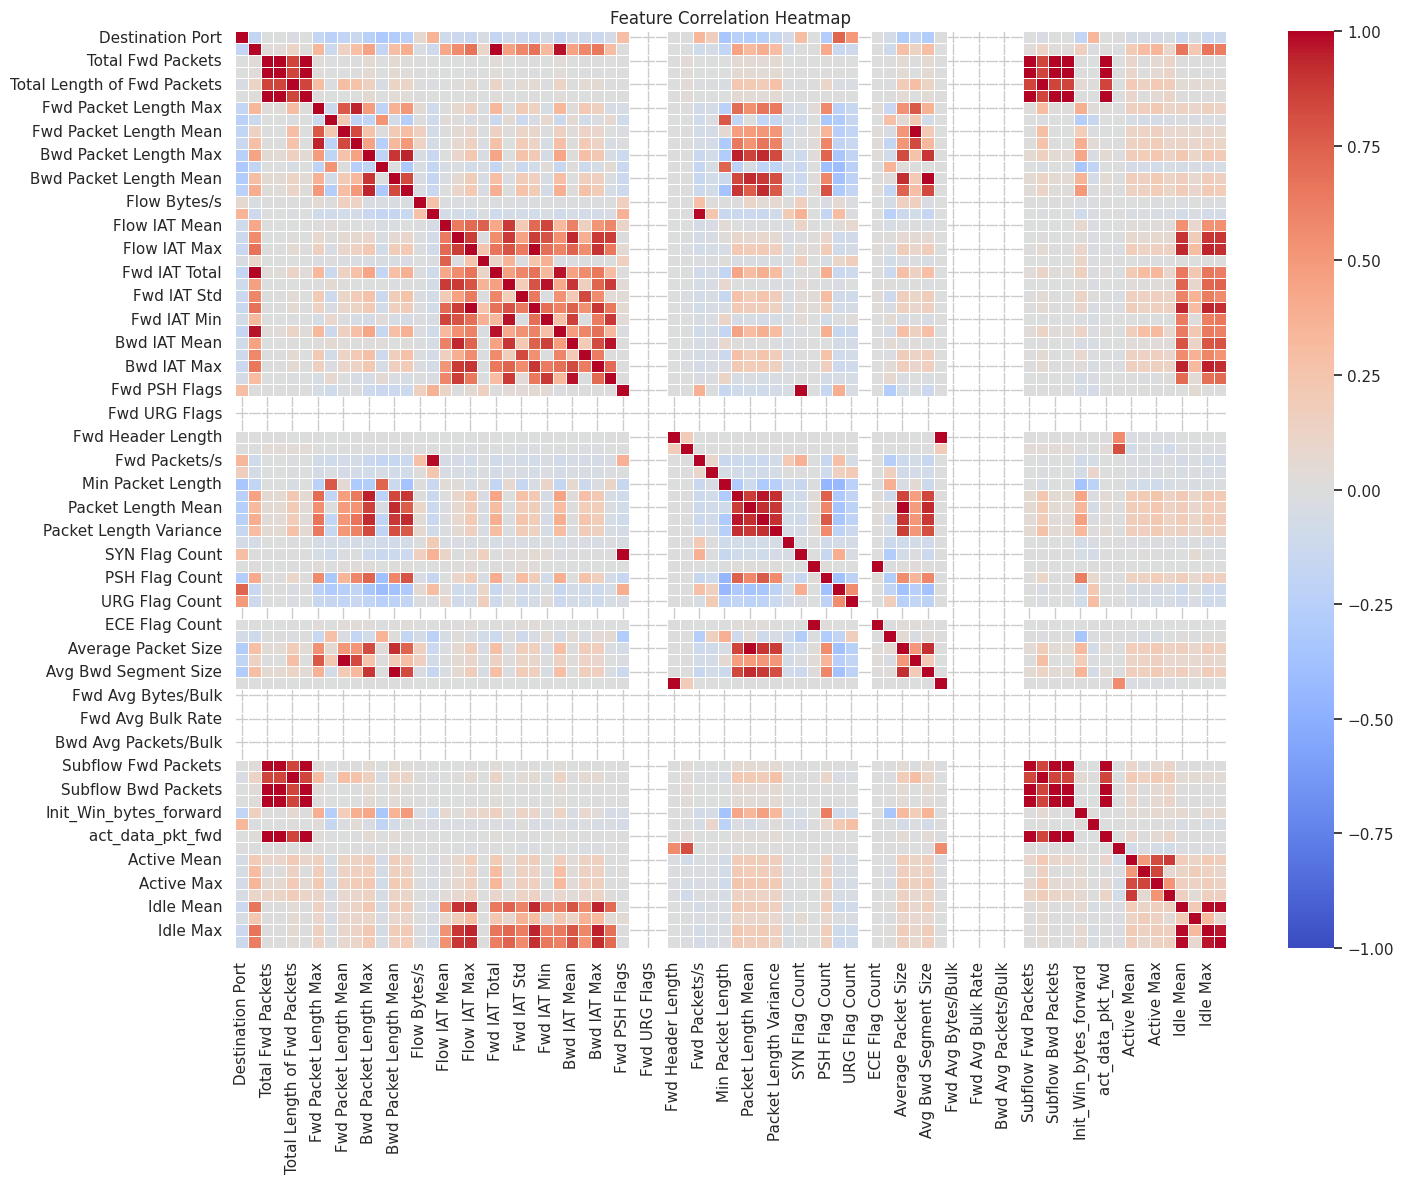

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure your data is numeric and clean (use raw or normalized data)
data_cleaned = data.dropna().select_dtypes(include=[np.number])

# Compute correlation matrix
corr_matrix = data_cleaned.corr()

# Plot heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, linewidths=0.5, vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

In [ ]:
# Flatten and sort correlations
corr_pairs = corr_matrix.abs().unstack().sort_values(kind="quicksort", ascending=False)
high_corr = corr_pairs[(corr_pairs < 1.0) & (corr_pairs > 0.8)]
print(high_corr)

Subflow Fwd Packets       act_data_pkt_fwd         0.999509
 act_data_pkt_fwd        Subflow Fwd Packets       0.999509
 Total Fwd Packets        act_data_pkt_fwd         0.999509
 act_data_pkt_fwd         Total Fwd Packets        0.999509
                          Subflow Bwd Packets      0.999453
                                                     ...   
 Packet Length Variance   Avg Bwd Segment Size     0.816304
 min_seg_size_forward     Bwd Header Length        0.812537
 Bwd Header Length        min_seg_size_forward     0.812537
 Bwd Packet Length Std    PSH Flag Count           0.800302
 PSH Flag Count           Bwd Packet Length Std    0.800302
Length: 222, dtype: float64


16547/16547 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step


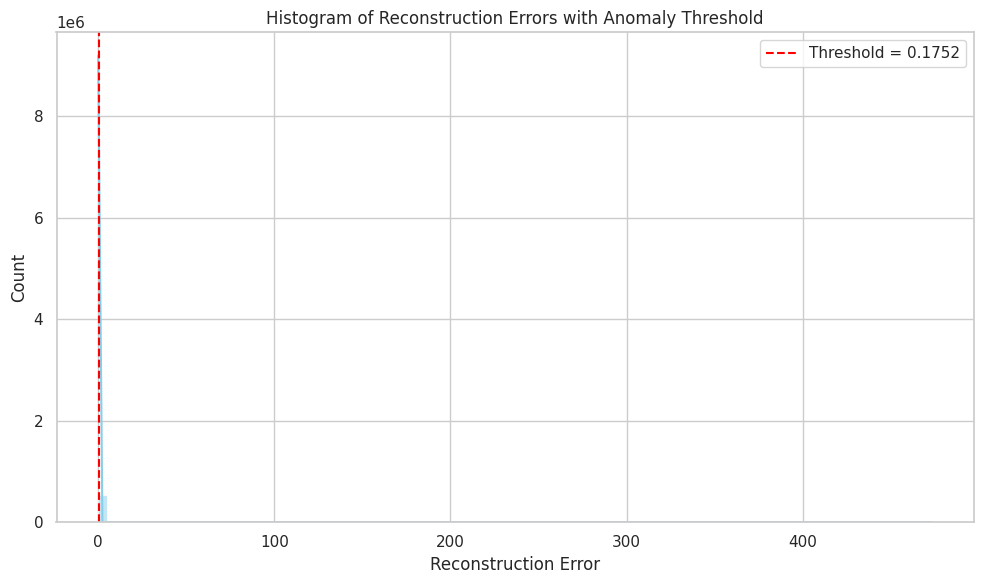

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Compute reconstruction errors
reconstructions = autoencoder.predict(data_scaled)
reconstruction_errors = np.mean(np.square(data_scaled - reconstructions), axis=1)

# Step 2: Define anomaly threshold (you might have already done this)
threshold = np.percentile(reconstruction_errors, 95)

# Step 3: Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(reconstruction_errors, bins=100, kde=True, color='skyblue')
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.4f}')
plt.title("Histogram of Reconstruction Errors with Anomaly Threshold")
plt.xlabel("Reconstruction Error")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import adjusted_rand_score

# Assuming you have true labels and clustering results
true_labels = labels.factorize()[0]  # Converts string labels to integers
predicted_clusters = clusters         # Output from KMeans

ari = adjusted_rand_score(true_labels, predicted_clusters)
print("Adjusted Rand Index (ARI):", round(ari, 4))

AttributeError: 'NoneType' object has no attribute 'factorize'

In [ ]:
# Check if 'Label' column exists
if 'Label' in data.columns:
    labels = data['Label'].copy()
else:
    print("No 'Label' column found in dataset.")
    labels = None

No 'Label' column found in dataset.
